In [13]:
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAXResults


In [10]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (119132, 23)


In [11]:
label_col = ['travel_time_seconds']
feature_cols = [c for c in X_full.columns if c not in ['travel_time_seconds','speed','evt_duration']]
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_total', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
lag_features = ['lag1', 'lag2', 'lag3']
tmc_features = ['miles']
full_features = time_features + evt_features + lag_features + tmc_features

## ARIMA per-TMC baseline (not Pooled model)

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


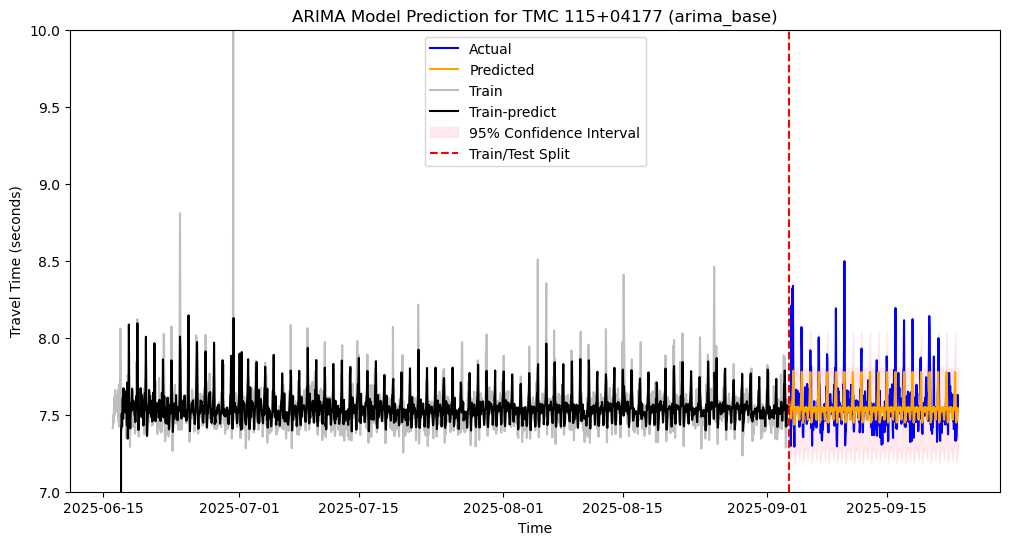

In [ ]:
# Visualize model prediction on each segment
# (tmc, (model, X_test, y_test))
tmc = '115+04177'
model_name = 'arima_base'
target_col = 'travel_time_seconds'

grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
time_series = grp.index.get_level_values('time_bin')

n_test = int(len(grp) * 0.2)
y_train = grp[target_col].iloc[:-n_test].values
y_test  = grp[target_col].iloc[-n_test:].values

model = pm.ARIMA(order=(1, 0, 1),           # (p, d, q)
                 seasonal_order=(1, 1, 1, 24),  # (P, D, Q, s)
                 with_intercept=True)

# model.fit(y_train)
pred_in = model.predict_in_sample()
pred, conf_int = model.predict(n_periods=n_test, return_conf_int=True)

# pred = models[model_name][tmc][0].predict(len(models[model_name][tmc][2]))
# pred = m[1][0].predict(n_periods=len(m[1][2]))

plt.figure(figsize=(12,6))
plt.plot(time_series[-n_test:], y_test, label='Actual', color='blue')
plt.plot(time_series[-n_test:], pred, label='Predicted', color='orange')
plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
plt.fill_between(time_series[-n_test:],
                 conf_int[:, 0], conf_int[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
plt.ylim([7,10])
plt.title(f'ARIMA Model Prediction for TMC {tmc} (no exog)')
plt.xlabel('Time')
plt.ylabel('Travel Time (seconds)')
plt.legend()
plt.show()

In [ ]:
# test exogenous features
tmc = '115+04187'
target_col = 'travel_time_seconds'

EXOG_CONFIGS = {
    "base": [],
    "evt_total": ["evt_total"],
    "evt": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc'],
    "cyc": ['hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend'],
    "full": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc',
            'hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend']
}
# ======= choose exogenous variables =======
config_name = "evt_total"
exog_cols = EXOG_CONFIGS[config_name]
# ========================
grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
time_series = grp.index.get_level_values('time_bin')

n_test = int(len(grp) * 0.2)
y_train = grp[target_col].iloc[:-n_test].values
y_test  = grp[target_col].iloc[-n_test:].values

X_train = grp[exog_cols].iloc[:-n_test]
X_test  = grp[exog_cols].iloc[-n_test:]

model = sm.tsa.SARIMAX(
    y_train,
    order=(1,0,0),
    seasonal_order=(1,1,1,24),
    exog=X_train[exog_cols]
)
res = model.fit()

# or load model from file
# model_path = Path(f'../models/sarimax/sarimax_{tmc}_{config_name}.pkl')
# res = SARIMAXResults.load(model_path)
# print(res.summary())

forecast = res.get_forecast(steps=len(y_test), exog=X_test[exog_cols])
pred = forecast.predicted_mean
pred_in = res.fittedvalues

conf_int = forecast.conf_int()
try:
    conf_low = conf_int["lower y"]
    conf_upp = conf_int["upper y"]
except:
    conf_low = conf_int[:,0]
    conf_upp = conf_int[:,1]

plt.figure(figsize=(12,6))
plt.plot(time_series[-n_test:], y_test, label='Actual', color='blue')
plt.plot(time_series[-n_test:], pred, label='Predicted', color='orange')
plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
plt.fill_between(time_series[-n_test:],
                 conf_low, conf_upp,
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
# plt.ylim([7,10])
plt.title(f'ARIMA Model Prediction for TMC {tmc} (with {config_name} exog)')
plt.xlabel('Time')
plt.ylabel('Travel Time (seconds)')
plt.legend()
plt.show()

UnpicklingError: invalid load key, 'x'.

Insight:
Explanation
Event-only model: Events have no significant or detectable effect; likely sparse or misaligned.
Cyclic-time model: Strong, significant daily and weekly effects; fits data better (ΔAIC = 33).
Interpretation: Travel time variation is mostly predictable from time-of-day and day-of-week, not raw event counts.


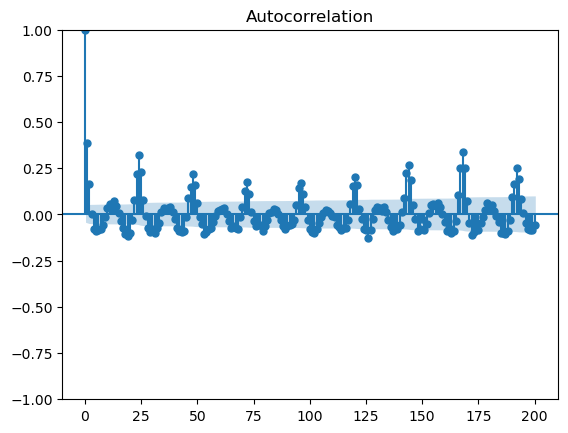

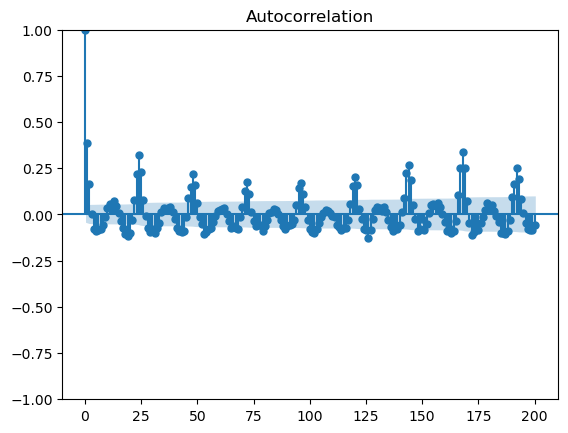

In [ ]:
# autocorrelation function (ACF) of your training series (y_train), up to 200 lags (hours).
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_train, lags=200)

In [9]:
# Save trained models
import joblib
# joblib.dump(models, '../models/arima_models.pkl')
joblib.dump(df_results, '../models/sarimax.pkl')
joblib.dump(total_score, '../models/sarimax_scores.pkl')


['../models/sarimax_scores.pkl']

In [ ]:
# Load trained models to see which config is the best

import joblib
model_path = '../models/sarimax/sarimax_results.pkl'
res = joblib.load(model_path)

             AIC          BIC  MAPE_train  MAPE_test  NRMSE_train  NRMSE_test  \
0   -2357.409156 -2335.246669    2.317467   1.188526     0.113724    0.017697   
1   -2355.409155 -2327.706047    2.317470   1.188537     0.113724    0.017697   
2   -2347.409155 -2297.543561    2.317470   1.188537     0.113724    0.017697   
3   -2382.509440 -2321.562603    2.294285   1.154101     0.113699    0.017450   
4   -2372.509422 -2283.859478    2.294288   1.154109     0.113699    0.017450   
..           ...          ...         ...        ...          ...         ...   
245  -437.209957  -415.047471    2.249761   1.161262     0.113371    0.017764   
246  -435.209953  -407.506845    2.249761   1.161262     0.113371    0.017764   
247  -427.209953  -377.344359    2.249761   1.161262     0.113371    0.017764   
248  -465.707825  -404.760988    2.225677   1.130091     0.113362    0.017389   
249  -455.707822  -367.057877    2.225681   1.130099     0.113362    0.017389   

     corr_train  corr_test 

In [33]:
res

,AIC,BIC,MAPE_train,MAPE_test,NRMSE_train,NRMSE_test,corr_train,corr_test,model_summary,converged,TMC,Config
0,-2357.409156,-2335.246669,2.317467,1.188526,0.113724,0.017697,0.045480,0.593150,SARIMAX ...,True,115+04177,base
1,-2355.409155,-2327.706047,2.317470,1.188537,0.113724,0.017697,0.045479,0.593141,SARIMAX ...,True,115+04177,evt_total
2,-2347.409155,-2297.543561,2.317470,1.188537,0.113724,0.017697,0.045479,0.593141,SARIMAX ...,True,115+04177,evt
3,-2382.509440,-2321.562603,2.294285,1.154101,0.113699,0.017450,0.048049,0.607659,SARIMAX ...,True,115+04177,cyc
4,-2372.509422,-2283.859478,2.294288,1.154109,0.113699,0.017450,0.048050,0.607656,SARIMAX ...,True,115+04177,full
...,...,...,...,...,...,...,...,...,...,...,...,...
245,-437.209957,-415.047471,2.249761,1.161262,0.113371,0.017764,0.053932,0.557944,SARIMAX ...,True,115P05165,base
246,-435.209953,-407.506845,2.249761,1.161262,0.113371,0.017764,0.053932,0.557943,SARIMAX ...,True,115P05165,evt_total
247,-427.209953,-377.344359,2.249761,1.161262,0.113371,0.017764,0.053932,0.557943,SARIMAX ...,True,115P05165,evt
248,-465.707825,-404.760988,2.225677,1.130091,0.113362,0.017389,0.056144,0.585277,SARIMAX ...,True,115P05165,cyc


In [39]:
_x = 'MAPE_train'
_y = 'NRMSE_test'
for tmc, res_grp in res.groupby('TMC'):
    # get the best config
    best_idx = res_grp[_y].idxmin()
    best_res = res_grp.loc[best_idx]['Config']
    print(f"TMC {tmc}: Best Config = {best_res}, Train {res_grp.loc[best_idx][_x]:.2f}, Test {res_grp.loc[best_idx][_y]:.2f}")

markers = {
    'base': 'o',
    'evt_total': 's',
    'evt': '^',
    'cyc': 'D',
    'full': 'X'
}
# plt.figure(figsize=(12,6))
# for config, res_grp in res.groupby('Config'):
#     plt.scatter(res_grp[_x], res_grp[_y], label=config, alpha=0.5, marker=markers[config])
#     # plt.plot([0,1],[0,1], color='gray', linestyle='--')
#     # plt.xlim([0,1])
#     # plt.ylim([0,1])
#     plt.xlabel(_x)
#     plt.ylabel(_y)
#     plt.title('SARIMAX Model Comparison Across Configurations')
#     plt.legend()
# plt.show()

TMC 115+04177: Best Config = cyc, Train 2.29, Test 0.02
TMC 115+04178: Best Config = full, Train 2.85, Test 0.05
TMC 115+04179: Best Config = cyc, Train 2.68, Test 0.07
TMC 115+04180: Best Config = evt_total, Train 2.54, Test 0.44
TMC 115+04181: Best Config = cyc, Train 2.95, Test 0.06
TMC 115+04182: Best Config = cyc, Train 2.21, Test 0.01
TMC 115+04183: Best Config = cyc, Train 2.08, Test 0.01
TMC 115+04184: Best Config = base, Train 2.06, Test 0.01
TMC 115+04185: Best Config = cyc, Train 2.15, Test 0.08
TMC 115+04186: Best Config = full, Train 2.32, Test 0.11
TMC 115+04187: Best Config = evt_total, Train 6.00, Test 0.51
TMC 115+04188: Best Config = evt_total, Train 8.35, Test 0.45
TMC 115-04177: Best Config = cyc, Train 2.35, Test 0.02
TMC 115-04178: Best Config = cyc, Train 2.31, Test 0.03
TMC 115-04179: Best Config = cyc, Train 2.83, Test 0.06
TMC 115-04180: Best Config = cyc, Train 2.24, Test 0.07
TMC 115-04181: Best Config = full, Train 2.48, Test 0.03
TMC 115-04182: Best Config